
Estimate best MSM for a given system
----------
This notebook demonstrates how to compute metastable states and visualize their structures, how to compute the equilibrium probabilities of and transition rates between metastable states, and how to compute transition pathways. It covers everything I (Ryan M.) learned at the 2016 PyEmma workshop in Berlin.

The notebook uses TICA and Bayesian HMM estimation to determine the metastable states of your system and calculates the maximum likelihood MSM among those metastable states. The intuitive (and, in fact, mathematical) understanding of what's going on is that there is a distribution of possible Markov State Models to describe both the microstates (TICA, k-means and maximum likelihood MSM estimation[1]) and macrostates (Bayesian HMM estimation[2,3]). We'll find the best of both using (approximations of) Bayes' rule.

To save any plots, do 
savefig(filename.png) after the line of code where the desired figure is generated.

More frames is better. I had trouble running on systems with 1000 frames or fewer. Looks like it needs more data than that.

In [1]:
# Setup things 
# Dependencies
import pyemma
import matplotlib.pylab as plt
import numpy as np
import pyemma.coordinates as coor
%pylab inline
import math
import pyemma.msm as msm
import pyemma.plots as mplt
import shortcuts
import mdtraj

# function for getting all pairs of residues
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
### Fill in what you're working on
trajfile = "/Users/melvrl13/Documents/groupStuff/ClusteringTrials/Trajectories/MetRSComplex/1QQT_WT_300ns_R2-3_NucProtZn_str5_Align.dcd"
topfile = "/Users/melvrl13/Documents/groupStuff/ClusteringTrials/Trajectories/MetRSComplex/1qqt.namd.pdb" #must be pdb

protein_res_count = 546
ligand_res_count = 77
#ligand_res_num = 624

#protein_residues = range(protein_res_count)
ligand_residues = range(protein_res_count, ligand_res_count + protein_res_count)

residue_pairs = cartesian((ligand_residues, [458]))

# Now let's read in the topology
feat = coor.featurizer(topfile)
# And pick what features to use
feat.add_residue_mindist(residue_pairs=residue_pairs, scheme='closest-heavy', threshold=0.5)
#http://www.emma-project.org/v1.2.2/api/generated/pyemma.coordinates.featurizer.html

# I'm not doing things in memory, so arbitrarily large trajectories should be fine.
# Can be sped up by loading into memory -- ref pyemma docs
# Let's make sure everything was read in as expected
inp = coor.source(trajfile, feat) #not read into memory
X = inp.get_output()
print('number of trajectories = ', len(X))
print('trajectory length = ', X[0].shape[0])
print('total data = ', len(X)*X[0].shape[0],)
print('number of dimension = ', X[0].shape[1])
#feat.describe()

/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/pyEMMA-2.0.2-py3.4-macosx-10.5-x86_64.egg/pyemma/coordinates/data/featurizer.py:1187: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if scheme != 'ca' and residue_pairs == 'all':


number of trajectories =  1
trajectory length =  12002
total data =  12002
number of dimension =  77


TICA and clustering
---------------
Now we reduce the dimension of the input coordinates to the subspace of slow coordinates using TICA [3]. By default, TICA will choose a number of output dimensions to cover 95% of the kinetic variance and scale the output to produce a kinetic map [4].


Retained dimension:  4
15-03-16 16:22:11 coordinates.clustering.KmeansClustering[2] INFO     Cluster centers converged after 3 steps.


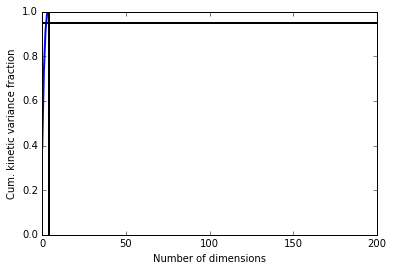

In [4]:
tica_lag = 20  # tica lagtime
tica_obj = coor.tica(X, lag=tica_lag)
Y = tica_obj.get_output()  # get tica coordinates
print('Retained dimension: ', tica_obj.dimension()) 
plot(tica_obj.cumvar, linewidth=2)
plot([tica_obj.dimension(), tica_obj.dimension()], [0, 1], color='black', linewidth=2)
plot([0, 200], [0.95, 0.95], color='black', linewidth=2)
xlabel('Number of dimensions'); ylabel('Cum. kinetic variance fraction')
n_clusters = 15
clustering = coor.cluster_kmeans(Y, k=n_clusters, max_iter=100, tolerance=1e-10, fixed_seed=True)
dtrajs = clustering.dtrajs  # get discrete trajectories

Now we would like to characterize the clusters. The following miniscript calculates how many residues contacts Trna has one average, by cluster. Plotting a scatterplot of the number of contacts over the number of frames in each cluster, we see the following picture: we have one state with 0 contacts and many counts. This is good, because it means we have resolved the unbound state in a single cluster. We still have to see whether the crystallographic complex is amongst these states, but at least we can say something about the association / dissocation process based on these data.

/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


Microstate of unbound =  14


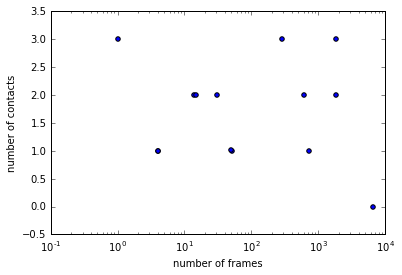

In [8]:
Dall = np.concatenate(dtrajs)
Xall = np.vstack(X)
distogram = np.zeros(n_clusters)
for i in range(n_clusters):
    Xsub = Xall[np.where(Dall==i)[0]]
    distogram[i] = Xsub.sum() / Xsub.shape[0]
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
scatter(histogram, distogram)
semilogx(); xlabel('number of frames'); ylabel('number of contacts')
i_micro_unbound = np.argmin(distogram)
print('Microstate of unbound = ', i_micro_unbound) 

Coarse-grained kinetic Model using a Hidden Markov Model
---------------
Now we estimate Bayesian Hidden Markov models (BHMMs) at a series of lag times. BHMMs are initialized from Markov state models and maximum-likelihood estimated as described in [2]. The statistical uncertainties are obtained by sampling the HMMs as described in [6].

15-03-16 16:47:12 msm.estimators.MaximumLikelihoodHMSM[0] WARNING  Requested coarse-grained model with 4 metastable states at lag=20.The ratio of relaxation timescales between 4 and 5 states is only 1.93093763251 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
15-03-16 16:47:12 msm.estimators.MaximumLikelihoodHMSM[0] WARNING  Requested coarse-grained model with 4 metastable states at lag=30.The ratio of relaxation timescales between 4 and 5 states is only 1.79307657469 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.
15-03-16 16:47:12 msm.estimators.MaximumLikelihoodHMSM[0] WARNING  Requested coarse-grained model with 4 metastable states at lag=50.The ratio of relaxation timescales between 4 and 5 states is only 1.66173945936 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


(10, 1000000)

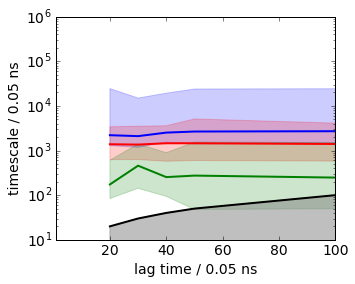

In [31]:
nstates = 4
lags=[20, 30, 40, 50, 100]
its = msm.timescales_hmsm(dtrajs, nstates, lags=lags, errors='bayes', nsamples=250, n_jobs=-1)
mplt.plot_implied_timescales(its, show_mean=False, units='0.05 ns', linewidth=2)
ylim(10, 1000000)

In [25]:
from pyemma.util.statistics import confidence_interval
i_micro_unbound = i_micro_unbound -1
def index_unbound_bound(bhmm):
    i_bound = np.argmax(bhmm.stationary_distribution)
    i_unbound = np.argmax(bhmm.observation_probabilities[:, i_micro_unbound])
    return i_unbound, i_bound

def pi2dG(pi, i_unbound, i_bound):
    delta_g = -0.6 * np.log(pi[i_bound]/pi[i_unbound])  # dG in kcal/mol
    delta_g -= 3.1  # volume correction to standard binding free energy
    return delta_g

def binding_free_energy(bhmm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound(bhmm)
    # MLE
    pi_mle = bhmm.stationary_distribution
    dG_mle = pi2dG(pi_mle, i_unbound, i_bound)
    # samples
    pi_samples = bhmm.sample_f('stationary_distribution')
    dG_samples = [pi2dG(pi_sample, i_unbound, i_bound) for pi_sample in pi_samples]
    l, r = confidence_interval(dG_samples, conf=conf)
    return dG_mle, l, r

def mfpt2kon(mfpt):
    mfpt *= 5e-11  # in seconds
    # volume fraction
    Nsim = 10604.0  # number of water molecules in our simulation
    Nstd = 55.55  # number of water molecules in standard volume
    concentration = Nstd / Nsim
    return 1./(mfpt*concentration)

def binding_rate(bhmm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound(bhmm)
    # MLE
    mfpt_mle = bhmm.mfpt(i_unbound, i_bound)
    kon = mfpt2kon(mfpt_mle)
    # samples
    mfpt_samples = bhmm.sample_f('mfpt', i_unbound, i_bound)
    kon_samples = [mfpt2kon(mfpt_sample) for mfpt_sample in mfpt_samples]
    l, r = confidence_interval(kon_samples, conf=conf)
    return kon, l, r

def mfpt2koff(mfpt):
    mfpt *= 5e-11  # in seconds
    k_off = 1./mfpt
    return k_off

def unbinding_rate(bhmm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound(bhmm)
    # MLE
    mfpt_mle = bhmm.mfpt(i_bound, i_unbound)
    koff = mfpt2koff(mfpt_mle)
    # samples
    mfpt_samples = bhmm.sample_f('mfpt', i_bound, i_unbound)
    koff_samples = [mfpt2koff(mfpt_sample) for mfpt_sample in mfpt_samples]
    l, r = confidence_interval(koff_samples, conf=conf)
    return koff, l, r

dG_stats = np.array([binding_free_energy(M) for M in its.models])
kon_stats = np.array([binding_rate(M) for M in its.models])
koff_stats = np.array([unbinding_rate(M) for M in its.models])

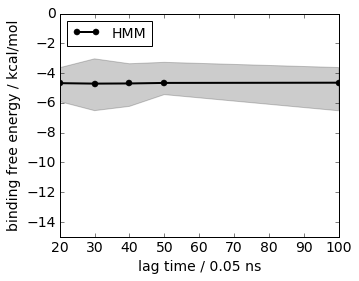

In [26]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize=(5,4))
# plot binding affinities
plot(its.lags, dG_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, dG_stats[:, 1], dG_stats[:, 2], alpha=0.2, color='black')
xlim(20,100); xlabel('lag time / 0.05 ns')
ylim(-15, 0); ylabel('binding free energy / kcal/mol')
legend(loc=2, fontsize=14)

[]

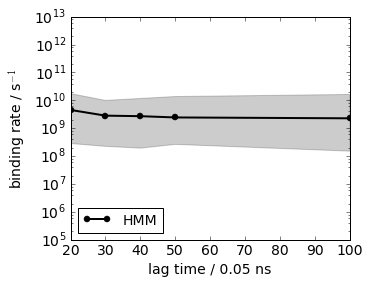

In [29]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(5,4))
# plot binding rates
plot(lags, kon_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, kon_stats[:, 1], kon_stats[:, 2], alpha=0.2, color='black')
legend(loc=3, fontsize=14)
xlim(20, 100); xlabel('lag time / 0.05 ns')
ylim(1e5, 1e13); ylabel('binding rate / s$^{-1}$'); semilogy()

[]

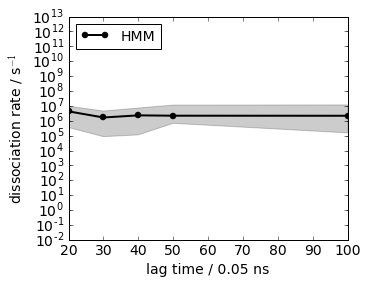

In [30]:
matplotlib.rcParams.update({'font.size': 14})
figure(figsize(5,4))
# plot binding rates
plot(lags, koff_stats[:, 0], linewidth=2, marker='o', color='black', label='HMM')
# compute and plot conf
fill_between(lags, koff_stats[:, 1], koff_stats[:, 2], alpha=0.2, color='black')
xlim(20, 100); xlabel('lag time / 0.05 ns')
ylim(1e-2, 1e13); ylabel('dissociation rate / s$^{-1}$')
legend(loc=2, fontsize=14)
semilogy()

References
---------------
1] Prinz, J.-H., H. Wu, M. Sarich, B. G. Keller, M. Senne, M. Held, J. D. Chodera, Ch. Schütte and F. Noé: Markov models of molecular kinetics: Generation and Validation. J. Chem. Phys. 134, 174105 (2011)

[2] Rabiner, L. R.: A tutorial on hidden markov models and selected applications in speech recognition. Proc. IEEE 77, 257--286 (1989)

[3] Noé, F., H. Wu, J.-H. Prinz and N. Plattner, N.: Projected and Hidden Markov Models for calculating kinetics and metastable states of complex molecules. J. Chem. Phys. 139, 184114 (2013)

[4] Djurdjevac, N., Sarich, M. & Schütte, C. Estimating the eigenvalue error of Markov State Models. Multiscale Model. Sim.

[5] P. Metzner, C. Schütte, and E. Vanden-Eijnden: “Transition Path Theory for Markov Jump Processes”. Mult. Mod. Sim. (2007)

[6] F. Noé, C. Schütte, E. Vanden-Eijnden, L. Reich, T. Weikl: “Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations”.